## Libreries

In [1]:
import pandas as pd
import numpy as np
import pickle

from transformers import AutoTokenizer, AutoModel, BertModel, BertTokenizer
import torch

## Data

In [2]:
A_train = pd.read_excel("../../data/train_task_C1.xlsx", index_col="id")
A_val = pd.read_excel("../../data/val_task_C1.xlsx", index_col="id")
A_test = pd.read_excel("../../data/test_task_C1.xlsx", index_col="id")

In [13]:
A_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11559 entries, 137889 to 148161
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Q_id      11559 non-null  int64 
 1   Q         11559 non-null  object
 2   A         11556 non-null  object
 3   label_Q   11559 non-null  int64 
 4   label     11559 non-null  int64 
 5   label_C1  11559 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 890.2+ KB


## Embeddings BETO

Load model [BETO](https://huggingface.co/dccuchile/bert-base-spanish-wwm-cased) from [huggingface](https://huggingface.co/) 🤗

In [3]:
model_name = "dccuchile/bert-base-spanish-wwm-cased"
beto_model = BertModel.from_pretrained(model_name)
beto_tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)
_ = beto_model.eval()
__ = beto_model.zero_grad()

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.we

In [4]:
beto_tokenizer.all_special_tokens, beto_tokenizer.all_special_ids

(['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]'], [3, 5, 1, 4, 0])

In [5]:
def get_cls_from_pair(text1, text2, maxlen=100):
    text1 = " ".join(str(text1).replace("\n", " ").split())
    text2 = " ".join(str(text2).replace("\n", " ").split())
    
    tokens1 = ["[CLS]", "[UNK]"]
    if text1 != "":
        tokens1 = beto_tokenizer.tokenize(text1)
        tokens1 = ["[CLS]"] + tokens1[:maxlen]
    if text2 != "":
        tokens2 = beto_tokenizer.tokenize(text2)
        tokens2 = tokens2[:maxlen]
        
    tokens = tokens1 + ["[SEP]"] + tokens2 + ["[SEP]"]
    input_ids = beto_tokenizer.convert_tokens_to_ids(tokens)    
    input_ids_tensor = torch.tensor(input_ids)
    
    cont = beto_model(input_ids_tensor.unsqueeze(0))
    cls_cont = cont.last_hidden_state[:, 0]
    return cls_cont[0].detach().numpy()

In [6]:
def get_embd(df, text1_col="Q", text2_col="A"):
    embeddings = []
    for ix in df.index:
        text1 = df.loc[ix][text1_col]
        text2 = df.loc[ix][text2_col]
        embd = get_cls_from_pair(text1, text2)
        embeddings.append(embd)
    o = pd.DataFrame(embeddings)
    o["id"] = df.index
    o = o.set_index("id")
    return o

In [7]:
%%time
embd_A_train = get_embd(A_train, text1_col="Q", text2_col="A")

CPU times: total: 3h 12min 27s
Wall time: 32min 16s


In [8]:
%%time
embd_A_val = get_embd(A_val, text1_col="Q", text2_col="A")

CPU times: total: 43min 13s
Wall time: 7min 14s


In [9]:
%%time
embd_A_test = get_embd(A_test, text1_col="Q", text2_col="A")

CPU times: total: 7min 20s
Wall time: 1min 13s


<AxesSubplot:>

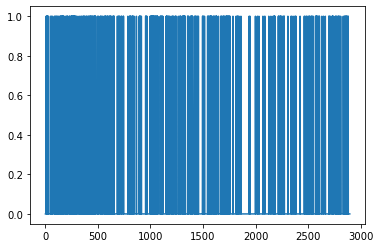

In [19]:
A_val.reset_index()["label"].plot()

In [22]:
A_train["label"].value_counts()

0    10019
1     1540
Name: label, dtype: int64

## Save features

In [10]:
embd_A_train.to_excel("../features/beto_pt_features_train_task_C1.xlsx")
embd_A_val.to_excel("../features/beto_pt_features_val_task_C1.xlsx")
embd_A_test.to_excel("../features/beto_pt_features_test_task_C1.xlsx")